In [1]:
import utils
from transformers import AutoTokenizer, TFAutoModelForCausalLM
from rouge_score import rouge_scorer, scoring
import matplotlib.pyplot as plt
import numpy as np

c:\Users\steph\anaconda3\envs\NLP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# setup ROUGE scorer and tokenizer

# can edit the different rouge scores we want; research which will be best
ROUGE_METRICS = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']
scorer = rouge_scorer.RougeScorer(ROUGE_METRICS, use_stemmer=True)
tokenizer = AutoTokenizer.from_pretrained('gpt2')
# TODO: ADD TRAINED ED MODEL
ed_model = None
tf_model = TFAutoModelForCausalLM.from_pretrained('../trained_models/gpt2-summarization/')

# Constants
TLDR = ' TL;DR '
MAX_LEN = 512


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at ../trained_models/gpt2-summarization/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [101]:
actual_headlines = {} # GET TESTING HEADLINES FOR EACH DATASET
predicted_headlines_ed = {} # GET ED PREDICTED HEADLINES FOR EACH DATASET
predicted_headlines_tf = {} # GET TF PREDICTED HEADLINES FOR EACH DATASET

def summarize_article(article, model):
    tokenized = tokenizer(article, return_tensors="np")
    outputs = model.generate(**tokenized, max_new_tokens=16, pad_token_id=50256)
    return tokenizer.decode(outputs[0])

with open('../data/test_data.txt', encoding='utf-8') as f:
    lines = f.readlines()
    for idx, line in enumerate(lines):
        article, actual_headline = line.strip().split(TLDR)
        article = article + TLDR
        actual_headlines[idx] = actual_headline
        predicted_headline_ed = summarize_article(article, ed_model).split(TLDR)[1].replace('<|endoftext|>', '.').strip()
        predicted_headline_tf = summarize_article(article, tf_model).split(TLDR)[1].replace('<|endoftext|>', '.').strip()
        predicted_headlines_ed[idx] = predicted_headline_ed
        predicted_headlines_tf[idx] = predicted_headline_tf
        print(f'{idx}:')
        print(f'\tactual: {actual_headline}')
        print(f'\tED predic: {predicted_headline_ed}')
        print(f'\tTF predic: {predicted_headline_tf}')

0:
	actual: Obama’s Secret to Surviving the White House Years: Books
	predic: Obama: A Life of Reading and Writing.
1:
	actual: The Smothers Brothers and the Birth of TV Buzz
	predic: 
2:
	actual: Drop in Gang Violence Drove New York City Shootings Below 1,000 in 2016
	predic: Gang Violence Is the New Normal.
3:
	actual: California Today: $8 Million in Tech Money for the Bay Area Arts
	predic: 
4:
	actual: Bombings Near Afghanistan’s Parliament Kill Dozens on Day of Assaults
	predic: Taliban Attack on Afghan Parliament Office in Kabul Kills Dozens.
5:
	actual: House Republicans Fret About Winning Their Health Care Suit
	predic: Trump’s Health Care Law Is a Big Win for Republicans.
6:
	actual: Silicon Valley’s Ambivalence Toward Trump Turns to Anger
	predic: Silicon Valley Is Still Confident Trump’s Order Will Work.
7:
	actual: How Washington State Upended Trump’s Travel Ban
	predic: Trump’s Travel Ban Is a Big Deal.
8:
	actual: Modi’s Cash Ban Brings Pain, but Corruption-Weary India Gr

In [110]:
# calculate ROUGE score(s) for each dataset
rouge_scores = {"ed" : [], "tf" : []}
for idx in actual_headlines.keys():
    curr_score_ed = scorer.score(actual_headlines[idx], predicted_headlines_ed[idx])
    curr_score_tf = scorer.score(actual_headlines[idx], predicted_headlines_tf[idx])
    if len(predicted_headlines_ed[idx]) > 0:
        rouge_scores['ed'].append(curr_score_ed)
        rouge_scores['tf'].append(curr_score_tf)
print(rouge_scores['ed'])
print(rouge_scores['tf'])

[{'rouge1': Score(precision=0.14285714285714285, recall=0.1, fmeasure=0.11764705882352941), 'rougeL': Score(precision=0.14285714285714285, recall=0.1, fmeasure=0.11764705882352941)}, {'rouge1': Score(precision=0.5, recall=0.21428571428571427, fmeasure=0.3), 'rougeL': Score(precision=0.5, recall=0.21428571428571427, fmeasure=0.3)}, {'rouge1': Score(precision=0.4, recall=0.36363636363636365, fmeasure=0.380952380952381), 'rougeL': Score(precision=0.3, recall=0.2727272727272727, fmeasure=0.28571428571428564)}, {'rouge1': Score(precision=0.36363636363636365, recall=0.4444444444444444, fmeasure=0.39999999999999997), 'rougeL': Score(precision=0.18181818181818182, recall=0.2222222222222222, fmeasure=0.19999999999999998)}, {'rouge1': Score(precision=0.4, recall=0.4444444444444444, fmeasure=0.4210526315789474), 'rougeL': Score(precision=0.3, recall=0.3333333333333333, fmeasure=0.3157894736842105)}, {'rouge1': Score(precision=0.5, recall=0.5, fmeasure=0.5), 'rougeL': Score(precision=0.5, recall=0

In [111]:
# calculate average ROUGE score(s) for each dataset
# NOTE: keeping the div by 0 failure to make debugging easier
def get_average_scores(rouge_scores, metric):
    avg_rouge_scores = {}
    for dataset in rouge_scores:
        precision = 0
        recall = 0
        fmeasure = 0
        for score in rouge_scores[dataset]:
            precision += score[metric].precision
            recall += score[metric].recall
            fmeasure += score[metric].fmeasure
        precision /= len(rouge_scores[dataset])
        recall /= len(rouge_scores[dataset])
        fmeasure /= len(rouge_scores[dataset])
        avg_rouge_scores[dataset] = scoring.Score(precision=precision, recall=recall, fmeasure=fmeasure)
    return avg_rouge_scores

avg_scores = {'ed' : {}, 'tf' : {}}
for metric in ROUGE_METRICS:
    avg_scores['ed'][metric] = get_average_scores(rouge_scores['ed'], metric)
    avg_scores['tf'][metric] = get_average_scores(rouge_scores['tf'], metric)
print(avg_scores['tf'])

def get_metrics(avg_scores, scores, metric):
    avg_metrics = {'Precision': (avg_scores[metric].precision), 'Recall': (avg_scores[metric].recall), 'Fmeasure': (avg_scores[metric].fmeasure)}
    metrics = {
        'Precision': [x[metric].precision for x in scores],
        'Recall': [x[metric].recall for x in scores],
        'fmeasure': [x[metric].fmeasure for x in scores]
    }
    return avg_metrics, metrics


Score(precision=0.2473076630971368, recall=0.20292078778920872, fmeasure=0.21584184674583132)


Text(0.5, 0.98, 'Frequency of Metrics')

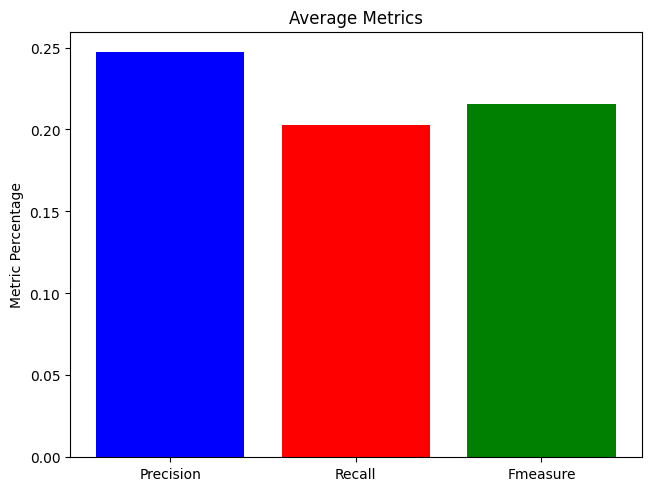

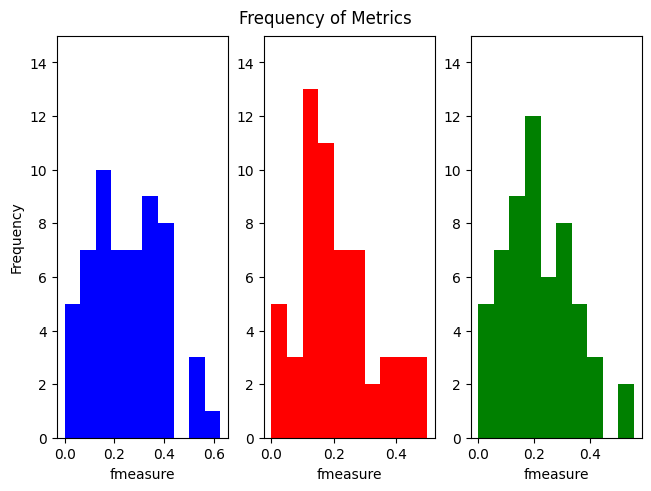

In [112]:
# Get metric data
avg_metrics = {'ed' : {}, 'tf' : {}}
metrics = {'ed' : {}, 'tf' : {}}

for metric in ROUGE_METRICS:
    avg_metrics['ed'][metric], metrics[metric] = get_metrics(avg_scores['tf'], rouge_scores['tf'], metric)
    avg_metrics['tf'][metric], metrics[metric] = get_metrics(avg_scores['tf'], rouge_scores['tf'], metric)

# Plot average scores across all tested samples
fig_avg, ax_avg = plt.subplots(layout='constrained')
ax_avg.bar(avg_metrics.keys(), avg_metrics.values(), color=['blue', 'red', 'green'])
ax_avg.set_ylabel('Metric Percentage')
ax_avg.set_title('Average Metrics')

# Plot frequency of specific scores across all tested samples
colors = ['blue', 'red', 'green']
fig_hist, ax_hist = plt.subplots(1, 3, layout='constrained')
for idx, key in enumerate(metrics.keys()):
    count, bin = np.histogram(metrics[key])
    ax_hist[idx].hist(bin[:-1], bin, weights=count, label=key, color=colors[idx])
    ax_hist[idx].set_xlabel(list(metrics.keys())[i])
    ax_hist[idx].set_ylim(0, 15)
ax_hist[0].set_ylabel('Frequency')
fig_hist.suptitle('Frequency of Metrics')